In [79]:
import os,sys
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np


""" Reading GRUAN errors.
    Inside each station directory e.g. 'LIN',
    we find subdirectories for each year, whihc contain the actual files. 
    Each netcdf file is named after the date, e.g. 
    LIN-RS-01_2_RS92-GDP_002_20070908T060000_1-000-001.nc """



station = "LIN"

db = '/mnt/scratch/scratch/federico/GRUAN_DATA/' 

# f = '/mnt/scratch/scratch/federico/GRUAN_DATA/LIN/2007/LIN-RS-01_2_RS92-GDP_002_20071231T180000_1-000-001.nc'
# select the hour of interest 
# T060000 , T120000, T180000, T000000 

hour = 'T120000'
station_name = 'Lindenberg(0-20001-0-10393)'

db_stat = db + '/' + station
years = os.listdir(db_stat)
years.sort()
print('Available years data for the station ', station , ' : ' , len(years) , " ", years  )

Available years data for the station  LIN  :  17   ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [88]:
def read_GRUAN(file, plevel):
    """ Extracts a dataframe for a GRUAN file """

    F = nc.Dataset(file)
    
    #print(F)
    df = pd.DataFrame.from_dict( { "time":F['time'][:],             "temp":F['temp'][:]             , "press":F['press'][:] ,
                                   "u_cor_temp":F["u_cor_temp"][:], "u_std_temp":F["u_std_temp"][:] , "u_temp":F["u_temp"][:],
                                   "wspeed":F["wspeed"], "u_wspeed":F["u_wspeed"] , 
                                   "rh":F["rh"] , "u_rh":F["u_rh"] } )
    
    df=df.dropna()

    df['press_int'] = df["press"].astype(int)
    
    df = df.drop_duplicates(subset=["press_int"],  keep='last' )


    df = df.loc[ df['press_int'] == plevel ] 
    #print("READ GRUAN PRESSURE  ", df[:10])

    return df

In [104]:
# data container

def make_save_df(db_stat, years, hour, save_csv=False):

    res = {}
    
    #for plevel in [200,500,7000,8500]:

    for plevel in [500]:

        res[plevel] = ''
        
        time = []
        
        temp,rh,wspeed = [],[],[]
        
        u_cor_temp, u_std_temp, u_temp  = [],[],[]
        u_rh = []
        u_wspeed = [] 

        files = []

        for y in years:

            print("Analysing year ", y )
            db_stat_y = db_stat + '/' + y 
            stat_files = [db_stat_y+'/'+f for f in os.listdir(db_stat_y) if hour in f ]

            #print('FILES ARE ', files)


            for g in stat_files:
                d = g.split("/")[-1]
                #print(g , d.split(hour)[0].split('_')[-1])
                date = d.split(hour)[0].split('_')[-1]


                df = read_GRUAN(g, plevel=plevel)

                df_p = df.loc[ df["press_int"] == plevel ]


                time.append(date)
                files.append(g)

                #print(df_p["temp"]) 
                temp.append(df_p["temp"].values)
                u_cor_temp.append(df_p["u_cor_temp"].values)
                u_std_temp.append(df_p["u_std_temp"].values)
                u_temp.append(df_p["u_temp"].values)
                
                rh.append(df_p["rh"].values)
                u_rh.append(df_p["u_rh"].values)
                
                wspeed.append(df_p["wspeed"].values)
                u_wspeed.append(df_p["u_wspeed"].values)
                

        all_results = pd.DataFrame( {"time":pd.to_datetime(time, format='%Y%m%d', errors='ignore'),
                             "temp":temp,
                             "u_cor_temp":u_cor_temp,
                             "u_std_temp":u_std_temp,
                             "u_temp":u_temp,
                             "wspeed":wspeed,
                             "u_wspeed":u_wspeed,
                             "u_rh":u_rh,
                             "rh":rh,
 
                                    
                                    } )

        all_results = all_results.sort_values(['time'])
        if save_csv:
            name = station + '_csv_' + str(plevel)
            all_results.to_csv(name, sep = '\t', index=False)


            #print(files)
            print(0)
        res[plevel] = all_results
    
    return res

res = make_save_df(db_stat, years, hour, save_csv=True)



Analysing year  2005
Analysing year  2006
Analysing year  2007
Analysing year  2008
Analysing year  2009
Analysing year  2010
Analysing year  2011
Analysing year  2012
Analysing year  2013
Analysing year  2014
Analysing year  2015
Analysing year  2016
Analysing year  2017
Analysing year  2018
Analysing year  2019
Analysing year  2020
Analysing year  2021
0


In [105]:
#all_results['temp'][:10]

In [109]:
def make_plot_GRUAN(res, station = '' , plevel = '', hour = '', var = 'temp'):
    
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()

    if var == 'temp':
        lab_1 = 'Temperature [K]'
        lab_2 = 'Uncertainty [K]'
        c_o = 'black'
        c_u = 'orange'
        y2_lim = [0,1]
        
    elif var == 'rh':
        lab_1 = 'Relative Humidity'
        lab_2 = 'Uncertainty'
        c_o = 'black'
        c_u = 'lime'
        y2_lim = [0,0.2]

    elif var == 'wspeed':
        lab_1 = 'Wind Speed [m/s]'
        lab_2 = 'Uncertainty [m/s]'
        c_o = 'black'
        c_u = 'slateblue'
        y2_lim = [0,5]

        
    fs = '13'
    
    plt.suptitle(station + ' , p=' + str(plevel) + ' [hPa] , hour=' + str(hour) )
    ax1.plot(res["time"], res[var]  , color = c_o , label = 'Observation')
    ax2.plot(res["time"], res["u_" + var], color = c_u, label= 'Uncertainty' )
    
    ax1.set_ylabel(lab_1, fontsize= fs) 
    ax2.set_ylabel(lab_2, fontsize= fs, color = c_u )
    ax2.set_ylim(y2_lim)
    
    plt.grid(color = 'lightgray', ls = ':')
    

    plt.show()
    

In [110]:
#print(np.array(all_results['time']))
#print(np.array(all_results["temp"]))

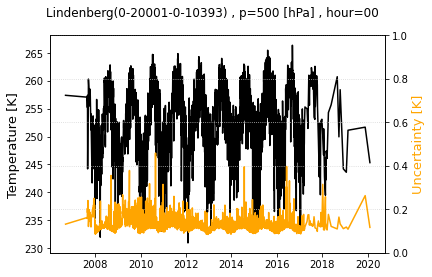

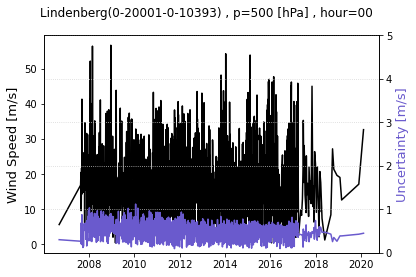

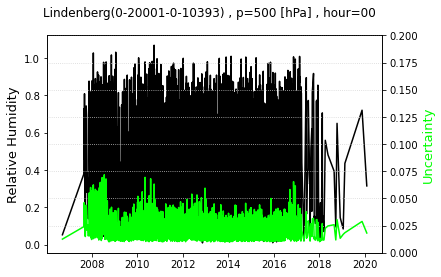

In [111]:
#for p in [200,500,850]:
for p in [500]:

    data = res[p]
    for v in ['temp','wspeed','rh']:
        a = make_plot_GRUAN(data, station = station_name, plevel=plevel, hour='00', var=v)


In [ ]:
a = make_plot_GRUAN(all_results, station = station_name, plevel=plevel, hour='00', what = 'temp')


In [73]:
# float32 u_cor_temp(time), float32 u_std_temp(time), float32 u_temp(time)

#F.variables
#time = F['time']
#temp = F['temp']
#press = F['press']
#u_cor_temp = F["u_cor_temp"]
#u_std_temp = F["u_std_temp"]
#u_temp = F["u_temp"]






